In [2]:
import torch
import sys
import numpy as np
from matplotlib import pyplot as plt

sys.path.append(r'/user/gr1/delphi/dghezzi/UNet')

from AttentionUnet import UNetWithAttention, inference_image, inference_dataset, img_kp_pred_and_gr, load_keypoints_from_csv

device = 'cuda' if torch.cuda.is_available() else 'cpu'


[INFO] Calcolo con binary_threshold=0.800 ...

[INFO] Calcolo con binary_threshold=0.805 ...

[INFO] Calcolo con binary_threshold=0.810 ...

[INFO] Calcolo con binary_threshold=0.815 ...

[INFO] Calcolo con binary_threshold=0.820 ...

[INFO] Calcolo con binary_threshold=0.825 ...

[INFO] Calcolo con binary_threshold=0.830 ...

[INFO] Calcolo con binary_threshold=0.835 ...

[INFO] Calcolo con binary_threshold=0.840 ...

[INFO] Calcolo con binary_threshold=0.845 ...

[INFO] Calcolo con binary_threshold=0.850 ...

[INFO] Calcolo con binary_threshold=0.855 ...

[INFO] Calcolo con binary_threshold=0.860 ...

[INFO] Calcolo con binary_threshold=0.865 ...

[INFO] Calcolo con binary_threshold=0.870 ...

[INFO] Calcolo con binary_threshold=0.875 ...

[INFO] Calcolo con binary_threshold=0.880 ...

[INFO] Calcolo con binary_threshold=0.885 ...

[INFO] Calcolo con binary_threshold=0.890 ...

[INFO] Calcolo con binary_threshold=0.895 ...

[INFO] Calcolo con binary_threshold=0.900 ...

[INFO] Calco

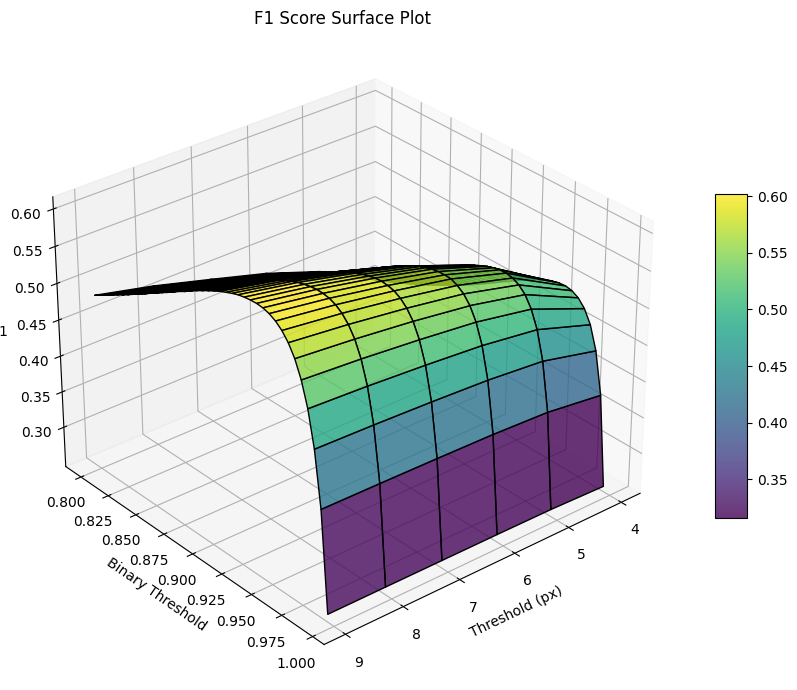

In [3]:
from AttentionUnet import inference_F1map_unet

datapath = '/user/gr1/delphi/dghezzi/SharedDataset_22500_2500_150_175_npy/UNet/800px'
output_path = '/user/gr1/delphi/dghezzi/UNet/SharedDataset/800px/output'
model_path = '/user/gr1/delphi/dghezzi/best_unet4.pth'


f1_matrix = inference_F1map_unet(
    dataset_path=datapath,
    model_path=model_path,
    img_size=800,
    pixel_thresholds=[4,5,6,7,8,9],
    binary_thresholds=np.arange(0.80, 1, 0.005),
    beta=1
)